In [5]:
import os

from skimage import io
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
from functools import partial
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
IMG_FOLDER = r"celebA_full_big_wild\images\train" 

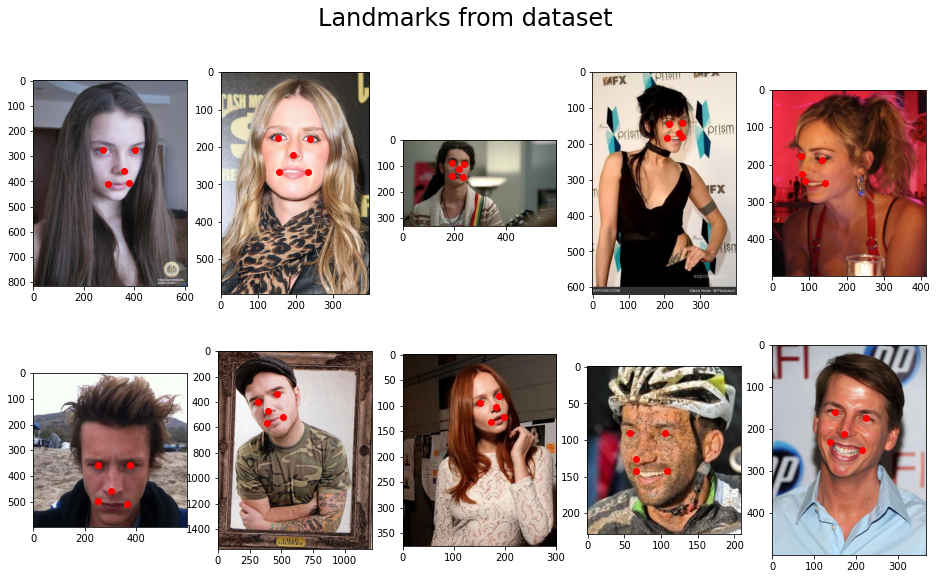

In [66]:
df_landmarks = pd.read_csv(
    "celebA_full_big_wild/list_landmarks_celeba.txt", skiprows=1, delim_whitespace=True)
df_bboxes = pd.read_csv(
    "celebA_full_big_wild/list_bbox_celeba.txt", skiprows=1, delim_whitespace=True)

# In-The-Wild dataset was used for training aligner
# It was split into 2 subsets for training detector beforehand
# Images with indexes before and after 20000
# The alignment model is trained on 182599 images
# This subset is also divedied into train and val later in this notebook
df_landmarks = df_landmarks[df_landmarks.index > '020000.jpg'].iloc[:]
df_bboxes = df_bboxes[df_bboxes.image_id > '020000.jpg'].iloc[:]

landmarks_cols = ['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x',
                  'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']
bboxes_cols = ['x_1','y_1','width','height']

df_landmarks = df_landmarks.reset_index().rename({"index": "image_id"}, axis=1)
#--------------------------------------------------------------------------------------
f, ax = plt.subplots(2,5, figsize=(16,9))
f.suptitle("Landmarks from dataset", fontsize=24)
ax = ax.ravel()
for axi, image_name in zip(ax,df_landmarks.sample(len(ax)).image_id):
    img = io.imread(os.path.join(IMG_FOLDER,image_name))
    landmarks_plot = df_landmarks.loc[df_landmarks.image_id == image_name, landmarks_cols].values[0]
    axi.imshow(img)
    for x, y in zip(landmarks_plot[0::2], landmarks_plot[1::2]):
        axi.plot(x, y, marker='o', c='r')
plt.show()

In [24]:
# Subtracting coordinate of left corner of bbox from landmarks
# This is done because the model will be trained on detected faces
df_landmarks.loc[::,df_landmarks.columns.str.contains("_y")] = df_landmarks.loc[::,df_landmarks.columns.str.contains("_y")].transform(lambda x: x-df_bboxes.y_1.values)
df_landmarks.loc[::,df_landmarks.columns.str.contains("_x")] = df_landmarks.loc[::,df_landmarks.columns.str.contains("_x")].transform(lambda x: x-df_bboxes.x_1.values)

In [26]:
RESIZE_SIZE = 218, 178
common_transforms = transforms.Compose([
      transforms.ToTensor(),
])

class FaceLandmarksDataset(Dataset):
    def __init__(self, landmarks_df, bboxes_df, image_folder, aug, transform=None):
        self.aug = aug
        self.image_filenames = landmarks_df.image_id.apply(lambda x: os.path.join(IMG_FOLDER, x)).values
        self.landmarks = landmarks_df[landmarks_cols].values.astype('float32') 
        self.bboxes = bboxes_df[bboxes_cols].values
        self.transform = transform
        assert len(self.image_filenames) == len(self.landmarks), "Lengths of image list and landmarks list don't match"

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image = io.imread(self.image_filenames[index])
        landmarks_image = torch.Tensor(self.landmarks[index].copy())
        x,y,w,h = self.bboxes[index]
        
        if self.transform:
            image = torchvision.transforms.functional.to_tensor(image)
            image = torchvision.transforms.functional.crop(
                image, 
                top=y, 
                left=x, 
                height=h, 
                width=w
            )
            # Resizing image
            y_trans, x_trans = (RESIZE_SIZE[0]/image.shape[1]), (RESIZE_SIZE[1]/image.shape[2])
            image = torchvision.transforms.functional.resize(img=image, size=RESIZE_SIZE)
            # Just rescaling values of landmarks for NN
            landmarks_image[0::2] = landmarks_image[0::2]*x_trans/RESIZE_SIZE[1] - 0.5
            landmarks_image[1::2] = landmarks_image[1::2]*y_trans/RESIZE_SIZE[0] - 0.5
            if self.aug:
                rangle=random.uniform(-30, +30)
                image, landmarks_image = rotate_im_landmarks(image, landmarks_image, rangle)
                
        return image, landmarks_image.float()


from sklearn.model_selection import train_test_split
df_train_land, df_val_land, df_train_bbox, df_val_bbox = train_test_split(df_landmarks, df_bboxes, test_size=0.2, random_state=9195)

dataset_train = FaceLandmarksDataset(df_train_land, df_train_bbox, IMG_FOLDER, True, common_transforms)
dataset_val = FaceLandmarksDataset(df_val_land, df_val_bbox, IMG_FOLDER, False, common_transforms)

train_loader = DataLoader(dataset_train, shuffle=False, batch_size=150)
valid_loader = DataLoader(dataset_val, batch_size=150)

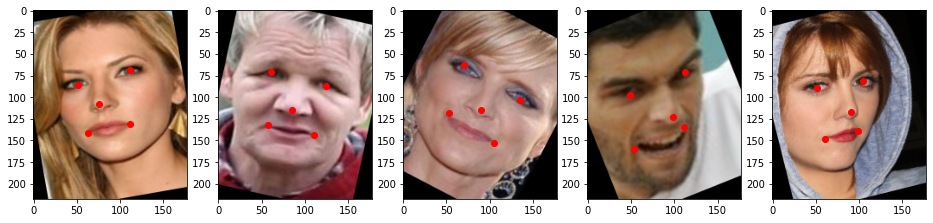

In [27]:
f, ax = plt.subplots(1,5, figsize=(16,9))
ax = ax.ravel()
for axi, image_i in zip(ax, np.random.choice(range(len(dataset_train)),len(ax))):
    img, landmarks = dataset_train[image_i]
    axi.imshow(img.permute(1,2,0))
    for x, y in zip((landmarks[0::2]+0.5)*RESIZE_SIZE[1], (landmarks[1::2]+0.5)*RESIZE_SIZE[0]):
        axi.plot(x, y, marker='o', c='r')
plt.show()

> By some reason the rotation transformation on landmarks dislocates them as rotation angle increases

#  Training Alignment model with ResNet18 as a backbone

In [28]:
from tqdm import tqdm, trange
from functools import partial
from IPython.display import clear_output

def plot_loss(losses_dict):
    fig, ax1 = plt.subplots(1,1, figsize=(12,5))
    # Loss graphs for train and val
    ax1.plot(losses_dict['train'], color='orange', label='train')
    ax1.plot(losses_dict['val'], color='dodgerblue', label='val' )
    ax1.set_title(f"Loss (best train={round(np.min(losses_dict['train']),6)}, best val={round(np.min(losses_dict['val']),6)})")
    ax1.legend(prop={"size":12})
    ax1.grid()
    ax1.set_yscale('log')
    plt.show()

In [29]:
class Network(nn.Module):
    # 10 classes for 2 coordinates of 5 landmarks
    def __init__(self,num_classes=10):
        super().__init__()
        self.model_name='resnet18'
        self.model=torchvision.models.resnet18(pretrained=True)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x


--------------------------------------------------
Epoch: 30  Train Loss: 0.0002706270  Valid Loss: 0.0004603879
--------------------------------------------------


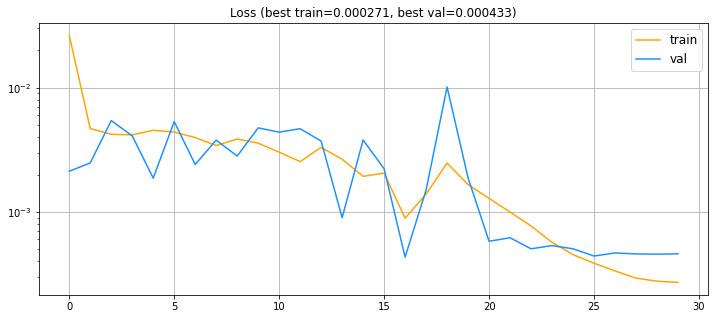

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:11:36<00:00, 263.21s/it]

Training Complete
Total Elapsed Time : 7896.4129292964935 s


In [32]:
tqdm = partial(tqdm, position=0, leave=True)

network = Network()
network.requires_grad_=True
network.to(device)   
loss_min = np.inf
num_epochs = 30

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(network.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

losses = {'train': [], "val": []}

start_time = time.time()
for epoch in trange(1,num_epochs+1):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    network.train()
    for images, landmarks in tqdm(train_loader):
        images = images.to(device)   
        landmarks = landmarks.to(device) 
        predictions = network(images)
        optimizer.zero_grad()
        loss_train_step = criterion(predictions, landmarks)
        loss_train_step.backward()
        optimizer.step()
        loss_train += loss_train_step.item()
    network.eval() 
    with torch.no_grad():
        for images, landmarks in tqdm(valid_loader):
            images, landmarks = next(iter(valid_loader))
            images = images.to(device)   
            landmarks = landmarks.to(device)   
            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)
            loss_valid += loss_valid_step.item()
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    losses['train'].append(loss_train)
    losses['val'].append(loss_valid)    
    if scheduler is not None:
        scheduler.step()
    clear_output()
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.10f}  Valid Loss: {:.10f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.10f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    #########################################################
    # Plotting learning losses
    plot_loss(losses)
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

In [11]:
network = Network()
align_model = 'face_landmarks_continuation-best.pth'
network.load_state_dict(torch.load(align_model))
network.requires_grad_=True
network.to(device)      

loss_min = np.inf
criterion = nn.MSELoss()

C:\Users\pqlet\my_virtualenvs\cuda_pytorch_113\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\pqlet\my_virtualenvs\cuda_pytorch_113\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--------------------------------------------------
Epoch: 12  Train Loss: 0.0018492207  Valid Loss: 0.0003100759
--------------------------------------------------


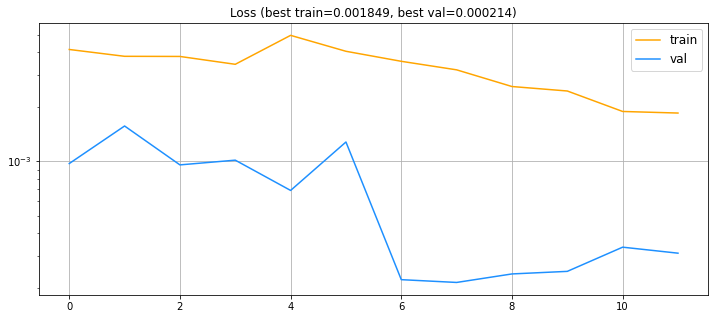

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [10:26:55<00:00, 3134.63s/it]

Training Complete
Total Elapsed Time : 37615.51176023483 s


In [12]:
# Continuing training with rotation augmentation
# (Written after started training)
tqdm = partial(tqdm, position=0, leave=True)
num_epochs = 12
optimizer = torch.optim.AdamW(network.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6])
losses = {'train': [], "val": []}
start_time = time.time()
for epoch in trange(1,num_epochs+1):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    network.train()
    for images, landmarks in tqdm(train_loader):
        images = images.to(device)   
        landmarks = landmarks.to(device)   
        predictions = network(images)
        optimizer.zero_grad()
        loss_train_step = criterion(predictions, landmarks)
        loss_train_step.backward()
        optimizer.step()
        loss_train += loss_train_step.item()
    network.eval() 
    with torch.no_grad():
        for images, landmarks in tqdm(valid_loader):
            images, landmarks = next(iter(valid_loader))
            images = images.to(device)   
            landmarks = landmarks.to(device)   
            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)
            loss_valid += loss_valid_step.item()
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    losses['train'].append(loss_train)
    losses['val'].append(loss_valid)    
    if scheduler is not None:
        scheduler.step()
    clear_output()
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.10f}  Valid Loss: {:.10f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks_continuation_2.pth') 
        print("\nMinimum Validation Loss of {:.10f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    #########################################################
    # Plotting learning losses
    plot_loss(losses)
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

# Checking model predictions

In [52]:
# network = Network()
# network.load_state_dict(torch.load("face_landmarks_continuation_2.pth"))
# network.to(device)
# network.eval();

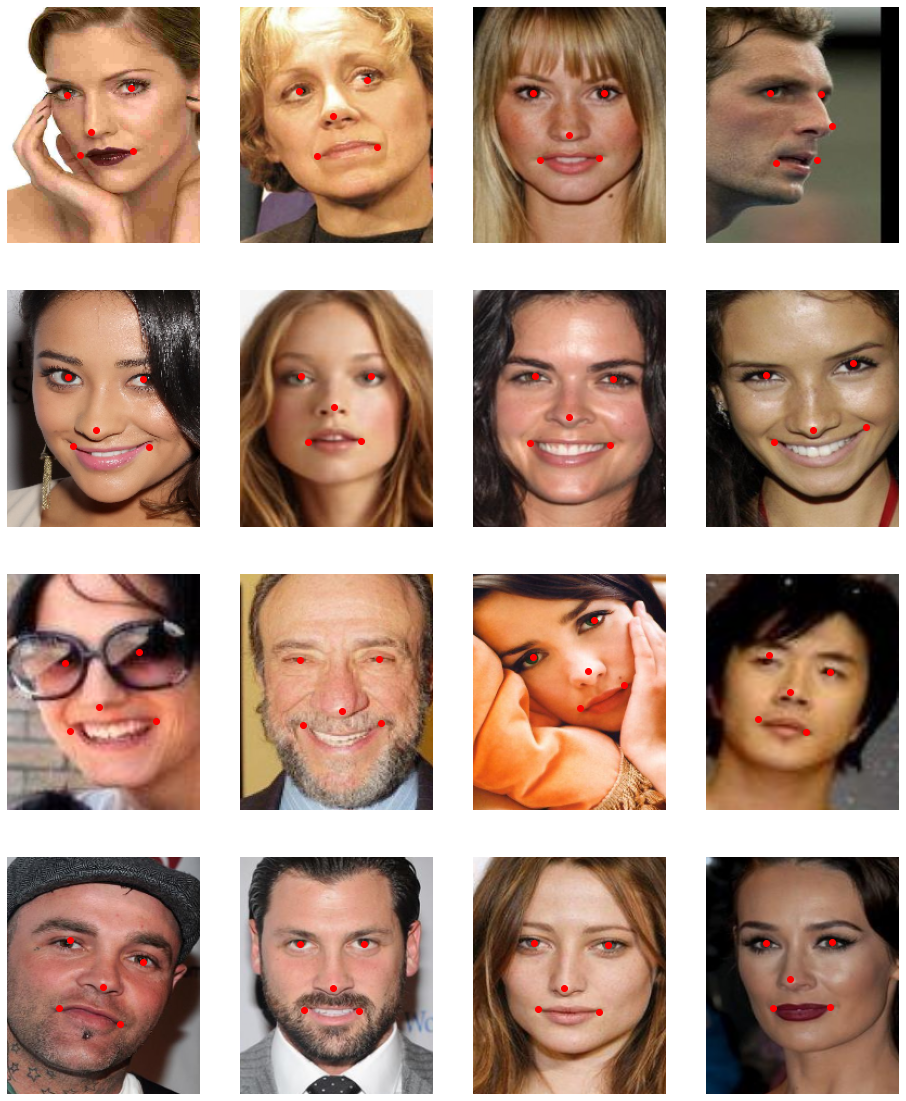

In [53]:
f, ax = plt.subplots(4,4, figsize=(16,20))
ax = ax.ravel()
offset = 68
for axi, image_i in zip(ax,range(offset, offset+len(ax))):
    img = dataset_val[image_i+offset][0].permute(1,2,0)
    axi.imshow(img)
    axi.axis("off")
    network.eval()
    with torch.no_grad():
        q = network(dataset_val[image_i+offset][0][None,:].to(device)).cpu()[0]
    for x, y in zip((q[0::2]+0.5)*RESIZE_SIZE[1], (q[1::2]+0.5)*RESIZE_SIZE[0]):
        axi.plot(x, y, marker='o', c='r')
plt.show()

>Results look fine 
>
>Though it's worth continue training with more augmentations and number of epochs

# Applying rotation

In [54]:
import random

def get_angle_bw_eyes(lx, ly, rx, ry):
    w = rx - lx
    h =  ly - ry
    angle = np.arccos(w / np.sqrt(h**2 + w**2)) * 180 / np.pi
    return angle if h < 0 else -angle

def rotate_im_landmarks(image, landmarks, angle):
        transformation_matrix = torch.tensor([
            [+np.cos(np.radians(angle)), -np.sin(np.radians(angle))], 
            [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]
        ])

        image = torchvision.transforms.functional.rotate(image, angle, 
                                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                        )
        new_landmarks = np.matmul(landmarks.view(-1,2), transformation_matrix)
        return image, new_landmarks.flatten()

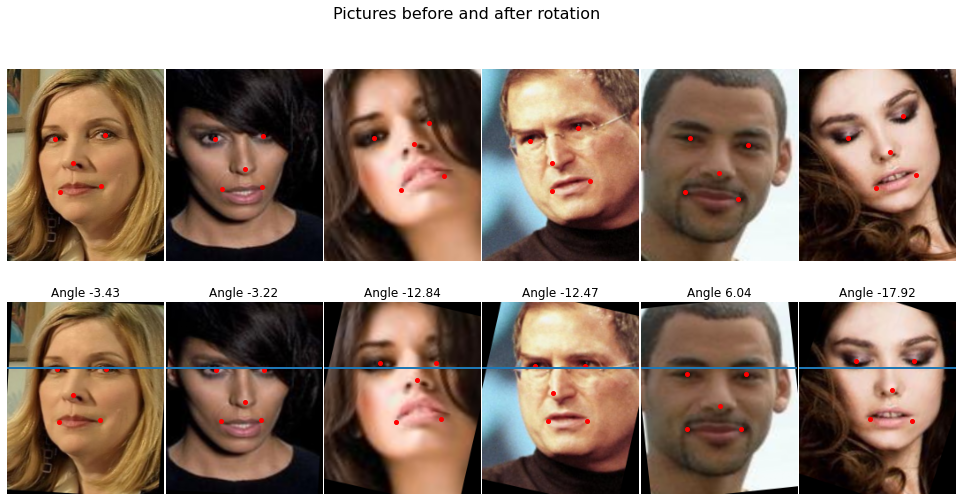

In [55]:
f, ax = plt.subplots(2,6, figsize=(17,8))
f.subplots_adjust(hspace=0.15, wspace=0.01)
f.suptitle("Pictures before and after rotation", fontsize=16)
ax = ax.ravel()
offset = 333
network.eval()
for axi, axii, image_i in zip(ax[:len(ax)//2], ax[len(ax)//2:],range(offset, offset+len(ax))):
    with torch.no_grad():
        q = network(dataset_val[image_i+offset][0][None,:].to(device)).cpu()[0]
    img = dataset_val[image_i+offset][0]
    axi.imshow(img.permute(1,2,0)) 
    # Rotating image 
    rotation_angle = get_angle_bw_eyes(*q[0:4]).item()
    img, q_rot = rotate_im_landmarks(img, q, rotation_angle)
    q_rot[0::2], q_rot[1::2] = (q_rot[0::2]+0.5)*RESIZE_SIZE[1], (q_rot[1::2]+0.5)*RESIZE_SIZE[0]
    axii.imshow(img.permute(1,2,0))  
    for x, y, x_rot, y_rot in zip((q[0::2]+0.5)*RESIZE_SIZE[1], (q[1::2]+0.5)*RESIZE_SIZE[0], 
                                  q_rot[0::2], q_rot[1::2]):
        axi.plot(x, y, marker='o', c='r', markersize=4)
        axii.plot(x_rot, y_rot, marker='o', c='r', markersize=4)
    # Horizontal Line
    axii.axhline(75, linewidth=2)
    axi.axis("off")
    axii.axis("off")
    axii.set_title("Angle {:.2f}".format(rotation_angle))
    
plt.show()

# Cropping faces on aligned images

In [56]:
NEW_IMG_SIZE = (112, 112)

In [57]:
def crop_resize_rotated_image(img_tensor, landmarks_coord_tensor):
    _, h, w = img_tensor.shape
    le, re, n, lm, rm = landmarks_coord_tensor.view(-1, 2)
    top_crop = min(le[1], re[1]) - 50
    left_crop = min(le[0], lm[0]) - 40
    height_crop = ((lm[1]+rm[1])/2) + 45 - top_crop
    width_crop = max(re[0], rm[0]) + 40 - left_crop
    new_img = torchvision.transforms.functional.resized_crop(
        img_tensor,
        top=top_crop.int(),
        left=left_crop.int(),
        height=height_crop.int(),
        width=width_crop.int(),
        size=NEW_IMG_SIZE
    )
    return new_img

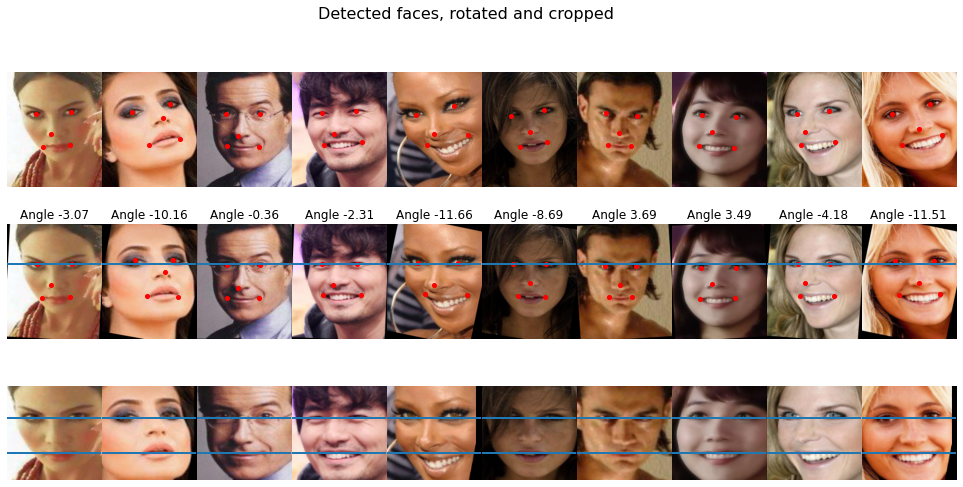

In [62]:
f, ax = plt.subplots(3,10, figsize=(17,8))
f.subplots_adjust(hspace=0.15, wspace=0.01)
f.suptitle("Detected faces, rotated and cropped", fontsize=16)
ax = ax.ravel()
offset = 888
network.eval()
for axi, axii, axiii, image_i in zip(ax[:len(ax)//3], ax[len(ax)//3:2*len(ax)//3], ax[2*len(ax)//3:],range(offset, offset+len(ax))):
    with torch.no_grad():
        q = network(dataset_val[image_i+offset][0][None,:].to(device)).cpu()[0]
        
    img = dataset_val[image_i+offset][0]
    axi.imshow(img.permute(1,2,0)) 
    # Rotating image 
    rotation_angle = get_angle_bw_eyes(*q[0:4]).item()
    img, q_rot = rotate_im_landmarks(img, q, rotation_angle)
    q_rot[0::2], q_rot[1::2] = (q_rot[0::2]+0.5)*RESIZE_SIZE[1], (q_rot[1::2]+0.5)*RESIZE_SIZE[0]
    axii.imshow(img.permute(1,2,0))  
    # Cropping rotated image
    img = crop_resize_rotated_image(img, q_rot)
    axiii.imshow(img.permute(1,2,0))
    
    for x, y, x_rot, y_rot in zip((q[0::2]+0.5)*RESIZE_SIZE[1], (q[1::2]+0.5)*RESIZE_SIZE[0], 
                                  q_rot[0::2], q_rot[1::2],
                                 ):
        axi.plot(x, y, marker='o', c='r', markersize=4)
        axii.plot(x_rot, y_rot, marker='o', c='r', markersize=4)
        
    # Horizontal Line
    axii.axhline(75, linewidth=2)
    axiii.axhline(38, linewidth=2)
    axiii.axhline(80, linewidth=2)
    
    # Miscellaneous params
    axii.set_title("Angle {:.2f}".format(rotation_angle))

# Removing axes
[ax_i.axis("off") for ax_i in ax] 
plt.show()

> Some faces have eyes above the common line, the rotation is imperfect.
>
> This all stems from imperfect landmark regression. The problem fully sticks out when it comes to rotation. 